In [272]:
import numpy as np
import torch
import scipy.stats as scs
from statsmodels.distributions.empirical_distribution import ECDF
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.nn as nn
import torch.optim as optim
import torch.distributions as dist
from pyhmc import hmc


In [7]:
# load all mnist data
import torchvision.datasets as datasets
import torchvision.transforms as transforms

np.random.seed(990109)
torch.manual_seed(990109)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
transform = transforms.Compose([transforms.ToTensor(),transforms.Lambda(lambda x: x.view(784))])
trainset = datasets.MNIST(root='.', train=True, download=False, transform=transform)
data_true = trainset.data.numpy()
data_true = data_true.reshape(data_true.shape[0], -1)



In [78]:
# Add Gaussian noise to dequentize
noise = scs.norm.rvs(0, 0.05, data_true.shape)
X_noisy_flat = (data_true + noise)

# Apply ECDF transformation
X_ecdf = np.zeros_like(X_noisy_flat)
ecdf_list = []
for dim in (range(X_noisy_flat.shape[1])):
    ecdf = ECDF(X_noisy_flat[:, dim])
    ecdf_list.append(ecdf)
    X_ecdf[:, dim] = np.clip(ecdf(X_noisy_flat[:, dim]), 1e-6, 1 - 1e-6)


100%|██████████| 784/784 [00:10<00:00, 73.43it/s]


In [212]:

# Apply inverse of standard normal CDF (ppf)
X_gaussian = scs.norm.ppf(X_ecdf).reshape(-1, 28,28)
y_gaussian = torch.ones(X_gaussian.shape[0], dtype=torch.long)
# make it a tensor with shape (n_samples, n_channels, height, width)
X_gaussian = torch.tensor(X_gaussian, dtype=torch.float32).unsqueeze(1)  # Add channel dimension

# Split the data into training and testing sets (50/50 split)
X_train, X_test, y_train, y_test = train_test_split(X_gaussian, y_gaussian, test_size=0.5, random_state=42)
# Create TensorDataset objects
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
# Create DataLoader objects
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [213]:
def reverse_transform(example):
    ''' 
    Reverse the transformation applied to the data using the ECDFs.
    
    input:
        example: torch.Tensor - the transformed example, of shape (1, 28, 28)

    output:
        original_example: np.array - the original example, of shape (28, 28)
    '''
    # Convert the tensor to a numpy array and remove the channel dimension
    example = example.squeeze().numpy().reshape(-1)
    
    # Apply the inverse of the standard normal CDF (ppf)
    example = scs.norm.cdf(example)
    
    # Apply the inverse ECDF transformation
    original_example = np.zeros_like(example)
    for i in range(len(example)):
        ecdf = ecdf_list[i]
        original_example[i] = np.interp(example[i], ecdf.y, ecdf.x)
    
    # Reshape back to the original image shape and denormalize
    original_example = original_example.reshape(28, 28) 
    
    return original_example

In [214]:

for k in train_loader:
    print(k[0].shape)
    break

torch.Size([64, 1, 28, 28])


In [139]:
train_dataset[0][0].shape

torch.Size([1, 28, 28])

In [176]:
28*28

784

In [215]:
# Define the ratio copula for MNIST data (28x28 images)

class CNN_ratio_MNIST(nn.Module):
    def __init__(self, in_shape=(1, 28, 28), normalising_cst=True, c=1.0):
        super(CNN_ratio_MNIST, self).__init__()
        self.normalising_cst = normalising_cst
        if self.normalising_cst:
            self.c = nn.Parameter(torch.tensor(c))

        self.model = nn.Sequential(
            nn.Conv2d(in_shape[0], 64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 1)  # Adjusted for 28x28 input images
        )

    def forward(self, x):
        logits = self.model(x).exp()
        if self.normalising_cst:
            logits = logits * self.c
        return logits

In [216]:
X_train[:2].shape

torch.Size([2, 1, 28, 28])

In [217]:

model = Classifier_Digits()
model(X_train[1:2])

tensor([[1.1892]], grad_fn=<MulBackward0>)

In [218]:
for inputs,labels in train_loader:
    print(inputs[0].shape)
    break

torch.Size([1, 28, 28])


In [253]:
17*501 /60

141.95

In [329]:
12*501/60

100.2

In [331]:


def loss_nce(r_p, r_q,p_size, q_size):
    v = q_size / p_size
    return (-(r_p /(v+r_p)).log()).mean() - v* ((v/(v+r_q)).log().mean()) 


# Define model
model = CNN_ratio_MNIST()

# Define loss function and optimizer
optimizer = optim.Adam(model.parameters(),lr=0.01)#, lr=0.0002, betas=(0.5, 0.999))

n_indep = 10

# Training loop
num_epochs = 20

GG_cov = np.cov(X_train.reshape(-1,28*28).T)

for epoch in (range(num_epochs)):
    model_GG_CNN.train()
    running_loss = 0.0
    noise_index = 0 

    epoch_GG_noise = torch.tensor(scs.multivariate_normal.rvs(mean=np.zeros(28*28), cov=GG_cov, size=469*n_indep).reshape(-1,1,28,28)).float()
    for inputs, labels in tqdm(train_loader):
        optimizer.zero_grad()
        r_p = model_GG_CNN(inputs).squeeze()
        epoch_GG_noise_here = epoch_GG_noise[noise_index:noise_index+inputs.shape[0]]
        r_q = model_GG_CNN( epoch_GG_noise_here).squeeze()
        noise_index += inputs.shape[0]
        loss = loss_nce(r_p, r_q,inputs.shape[0], epoch_GG_noise_here.shape[0])
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    if (epoch+1) % 100 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}, c: {model_GG_CNN.c.item()}")



100%|██████████| 469/469 [00:12<00:00, 38.22it/s]


In [332]:
model_GG_CNN = model
model_GG_CNN.eval()


# LL computation

X_train_flat = X_train.reshape(-1, 28*28)[:100]
X_test_flat = X_test.reshape(-1, 28*28)[:100]
GG_cov = np.cov(X_train_flat.T)
# Define the multivariate normal distribution with the given covariance matrix
GG_cov_tensor = torch.tensor(GG_cov, dtype=torch.float32)
multivariate_normal = dist.MultivariateNormal(loc=torch.zeros(28*28), covariance_matrix=GG_cov_tensor+torch.eye(GG_cov_tensor.size(0))*1e-6)
# Define the standard normal distribution
standard_normal = dist.Normal(loc=0, scale=1)
# Compute logpdf for the multivariate normal distribution
logpdf_multivariate_train = multivariate_normal.log_prob(X_train_flat)
logpdf_multivariate_test = multivariate_normal.log_prob(X_test_flat)
# Compute logpdf for the standard normal distribution and sum over the dimensions
logpdf_standard_train = standard_normal.log_prob(X_train_flat).sum(dim=1)
logpdf_standard_test = standard_normal.log_prob(X_test_flat).sum(dim=1)
# Compute GG_correction
GG_correction_train = logpdf_multivariate_train - logpdf_standard_train
GG_correction_test = logpdf_multivariate_test - logpdf_standard_test
# Compute means
mean_GG_correction_train = GG_correction_train.mean()
mean_GG_correction_test = GG_correction_test.mean()


# GG_CNN_Ratio

# Compute GG ratio alone
gg_CNN_ratio_train = model_GG_CNN(X_train[:100]).log().mean()
gg_CNN_ratio_test = model_GG_CNN(X_test[:100]).log().mean()

# Compute GG ratio corrected
gg_CNN_ratio_corrected_train = (GG_correction_train + model_GG_CNN(X_train[:100]).log()).mean()
gg_CNN_ratio_corrected_test = (GG_correction_test + model_GG_CNN(X_test[:100]).log()).mean()

# Print the results
print('GG CNN ratio alone', gg_CNN_ratio_train.item(), gg_CNN_ratio_test.item())
print('GG CNN ratio corrected ; GG_ratio full', gg_CNN_ratio_corrected_train.item(), gg_CNN_ratio_corrected_test.item())


GG CNN ratio alone 0.020968180149793625 0.025643741711974144
GG CNN ratio corrected ; GG_ratio full -3323376.5 -361856672.0


In [333]:

def compute_logpdf_corrections(X, model, batch_size=64):
    X_flat = X.reshape(-1, 28*28)
    GG_cov = np.cov(X_flat.T)
    GG_cov_tensor = torch.tensor(GG_cov, dtype=torch.float32)
    multivariate_normal = dist.MultivariateNormal(loc=torch.zeros(28*28), covariance_matrix=GG_cov_tensor)
    standard_normal = dist.Normal(loc=0, scale=1)

    logpdf_multivariate_sum = 0
    logpdf_standard_sum = 0
    model_log_sum = 0
    total_samples = 0

    for i in tqdm(range(0, X.shape[0], batch_size)):
        X_batch = X[i:i + batch_size]
        X_batch_flat = X_batch.reshape(-1, 28*28)
        logpdf_multivariate_sum += multivariate_normal.log_prob(X_batch_flat).sum().item()
        logpdf_standard_sum += standard_normal.log_prob(X_batch_flat).sum(dim=1).sum().item()
        model_log_sum += model(X_batch).log().sum().item()
        total_samples += X_batch.shape[0]

    avg_logpdf_multivariate = logpdf_multivariate_sum / total_samples
    avg_logpdf_standard = logpdf_standard_sum / total_samples
    avg_model_log = model_log_sum / total_samples

    GG_correction = avg_logpdf_multivariate - avg_logpdf_standard
    gg_CNN_ratio_corrected = GG_correction + avg_model_log

    return gg_CNN_ratio_corrected,avg_model_log

model_GG_CNN = model
model_GG_CNN.eval()

# Compute GG ratio corrected for train and test sets
gg_CNN_ratio_corrected_train,gg_CNN_ratio_train = compute_logpdf_corrections(X_train, model_GG_CNN)
gg_CNN_ratio_corrected_test, gg_CNN_ratio_test = compute_logpdf_corrections(X_test, model_GG_CNN)

# Print the results
print('GG CNN ratio base train ; GG_ratio base test', gg_CNN_ratio_train, gg_CNN_ratio_test)
print('GG CNN ratio corrected train ; GG_ratio corrected test', gg_CNN_ratio_corrected_train, gg_CNN_ratio_corrected_test)

100%|██████████| 469/469 [00:04<00:00, 95.61it/s] 

GG CNN ratio base train ; GG_ratio base test 0.027640063090622426 0.026442767407993475
GG CNN ratio corrected train ; GG_ratio corrected test 137.45446102663217 136.88832714240803


In [350]:

# HMC

def sample_GG_hmc(GG_ratio_model, num_samples, num_runs_hmc, num_burnin):
    ''' 
    Sample from the ratio model with HMC.
    
    args:
        GG_ratio_model: nn.Module - the GG ratio copula model
        num_samples: int - the number of samples to generate per HMC run
        num_runs_hmc: int - the number of HMC runs, each giving num_samples draws
        num_burnin: int - the number of burn-in steps for a single HMC run
    
    returns:
        samples,log_pdf with
        samples: np.array - the generated samples of shape (num_runs_hmc*num_samples, 64)
        log_pdf: np.array - the log-pdf of the samples of shape (num_runs_hmc*num_samples,)
    '''
    GG_ratio_model.eval()
    def log_GGratio_gauss(x):
        ''' 
        Compute the log-pdf of the GG_ratio copula model and its gradient at x. 
        Takes the ratio model and adjusts it by the GG factor to make it into a copula.
        '''
        # compute the top part of a GG_ratio copula logpdf and the gradients of that
        x_tensor = torch.tensor(x.reshape(1, 1, 28, 28), dtype=torch.float32, requires_grad=True)
        x_flat = x_tensor.reshape(-1, 28*28)
        # define N(Sigma) and N(0,1), then compute on x
        GG_cov_tensor = torch.tensor(GG_cov, dtype=torch.float32)
        multivariate_normal = dist.MultivariateNormal(loc=torch.zeros(28*28), covariance_matrix=GG_cov_tensor+torch.eye(GG_cov_tensor.size(0))*1e-6)
        standard_normal = dist.Normal(loc=0, scale=1)
        logpdf_multivariate = multivariate_normal.log_prob(x_flat)
        logpdf_standard = standard_normal.log_prob(x_flat).sum(dim=1)
        gg_correction = logpdf_multivariate - logpdf_standard
        # Compute the log of the ratio model
        log_ratio = torch.log(GG_ratio_model(x_tensor)).sum()
        # Compute the log probability of x under the standard normal distribution
        log_prob_standard = standard_normal.log_prob(x_tensor).sum()
        # Compute the final function value
        fun = log_ratio + gg_correction + log_prob_standard
        # Backward pass to compute the gradient
        fun.backward()
        grad_wrt_x = x_tensor.grad.reshape(1, -1)[0]
        
        return np.array(fun.item(), dtype=np.float64), np.array(grad_wrt_x.detach().numpy(), dtype=np.float64)

    samples = np.zeros((num_runs_hmc, num_samples, 28*28))
    log_pdf = np.zeros((num_runs_hmc, num_samples))
    x0_noise = np.zeros((num_runs_hmc, 28, 28))
    for hmc_run in tqdm( range(num_runs_hmc)):

        '''# pick x0 with highest r(x0) from random noise
        x0_proposal = torch.randn(1000, 1, 8, 8)
        r_noise = model(x0_proposal)
        x0_run = x0_proposal[np.argmax(r_noise.detach().numpy().flatten())]    
        '''
        '''# pick x0 randomly from N(0,1) 
        x0_run = torch.randn(1, 1, 28, 28)'''
        GG_cov = np.cov(X_train.reshape(-1,28*28).T)
        x0_run_np = scs.multivariate_normal.rvs(mean=np.zeros(28*28), cov=GG_cov, size=1).reshape(1,1,28,28)
        x0_run = torch.tensor(x0_run_np, dtype=torch.float32)
        samples_, log_pdf_, diagnostics_ = hmc(log_GGratio_gauss,
                            x0=x0_run.flatten().numpy(),
                            n_samples=num_samples,
                            return_logp=True,
                            n_burn=num_burnin,
                            return_diagnostics=True)
        
        print(diagnostics_)
        samples[hmc_run] = samples_
        log_pdf[hmc_run] = log_pdf_
        x0_noise[hmc_run] = x0_run

    return samples.reshape(-1,28*28), log_pdf.reshape(-1), x0_noise

sample_GG_CNN, log_pdf, x0_noises = sample_GG_hmc(GG_ratio_model=model_GG_CNN, 
                            num_samples=1, 
                            num_runs_hmc=5,
                            num_burnin=100)
print(sample_GG_CNN.shape)

 20%|██        | 1/5 [00:04<00:19,  4.91s/it]

{'pos': array([[ 1.14216647e+00, -1.00399399e+00, -1.16211315e+00,
        -8.40862897e-01,  3.12134147e-01, -7.60272092e-01,
         1.28382191e+00, -1.35486894e+00,  6.77479377e-01,
        -6.47432361e-01,  4.20008872e-01, -8.10518309e-02,
         3.89988355e-01,  1.17008112e+00,  4.90521557e-01,
         5.67447441e-01, -1.47735655e-01, -5.52044602e-01,
         1.24621251e-01,  1.56128331e+00,  1.31879153e+00,
        -6.11019018e-01,  4.28624871e-01,  1.16911522e+00,
        -4.93011941e-01, -4.78344363e-01,  6.73206405e-01,
        -8.17181228e-01,  2.64623322e-01, -1.13088606e+00,
        -1.01446802e+00, -3.13573521e-01, -6.26537811e-01,
         1.57093701e+00, -7.89086569e-01,  2.77558721e+00,
         1.66060895e+00, -9.18045004e-01, -1.12446442e+00,
        -1.57802803e+00,  1.08817979e+00, -1.45906444e+00,
         1.52512845e+00,  1.80554977e-01,  1.80159058e+00,
         2.12569850e-01, -3.97675784e-02,  4.19417621e-01,
         1.89767343e-01,  2.37186225e-01, -1.517

 40%|████      | 2/5 [00:09<00:14,  4.90s/it]

{'pos': array([[-1.05483512e+00, -2.35413696e-01,  1.37808737e+00,
        -1.42875017e+00, -1.82550121e+00, -1.29836517e+00,
        -1.11423915e-01, -2.55870651e+00, -2.21078958e-01,
         2.89477366e-01, -1.95359294e+00,  7.07815943e-01,
        -2.33200322e-03,  4.52692262e-01, -2.19121813e-01,
         9.49684896e-01, -1.63481058e-01, -8.42208378e-01,
        -1.27761101e-01, -2.02610885e+00, -1.06249543e+00,
        -1.95730826e+00,  1.65949263e-01,  1.49032900e-02,
         1.03103699e+00, -4.34067961e-01, -3.57848971e-01,
         2.23629090e+00, -2.32921466e-01, -4.33243931e+00,
        -2.31688609e+00,  1.16237211e+00,  1.26001044e+00,
        -4.05626775e-01, -5.26073822e-01,  1.30181552e+00,
         4.33883766e-01,  1.22636254e+00,  1.20320405e+00,
        -2.03328873e+00, -5.39044076e-01,  7.04689000e-01,
        -9.69630815e-01, -4.83913810e-01, -1.22189570e+00,
        -8.14294657e-01, -1.15307756e+00,  1.63312007e-01,
         2.59740210e-01, -1.67248543e-01,  1.508

 60%|██████    | 3/5 [00:14<00:09,  4.95s/it]

{'pos': array([[-1.34686434e+00, -1.98724753e-01, -1.08891258e+00,
         6.65220609e-02,  1.62567634e+00,  8.18432480e-01,
        -2.16233597e-01, -2.05474972e-01,  2.23592508e+00,
         3.00954155e-02,  9.83709744e-01, -1.12555917e+00,
        -1.00256087e+00, -4.18294056e-01,  1.29913561e+00,
        -1.39500152e-01,  3.09809208e-02, -3.21464156e-02,
         1.43578322e+00,  1.76559678e+00, -1.46877060e-01,
         6.56158986e-01,  6.89348125e-02, -2.05080145e+00,
         9.03073704e-01, -2.35230820e-01,  2.73334594e-01,
        -1.74330695e+00,  1.40473176e-01, -2.67135666e+00,
        -6.55942820e-01, -3.62382805e-01,  4.94333168e-01,
        -4.08156559e-01, -2.76005174e+00,  1.30576665e+00,
         1.93937784e+00,  1.34163859e+00, -9.44250404e-01,
        -1.09102907e+00, -9.01250896e-01,  5.78961532e-02,
         5.18897111e-01,  1.09928840e+00, -2.68578576e-01,
         3.47897622e-01, -1.13089805e+00,  1.65123919e+00,
        -7.41706513e-01,  8.10627676e-01,  2.434

 80%|████████  | 4/5 [00:20<00:05,  5.22s/it]

{'pos': array([[-6.13627376e-02, -5.36905481e-01, -1.40396691e-01,
         1.58958848e-02,  6.92421181e-02,  8.05010785e-01,
        -6.87338637e-01, -7.16796298e-01,  6.03849879e-01,
         4.76048204e-01, -8.23930369e-01, -1.06509852e+00,
         4.49200273e-01,  5.10309330e-01, -1.41433598e+00,
        -1.49812008e+00, -1.38018995e+00,  1.17408992e-01,
        -7.89165233e-01, -3.23224407e-01, -3.33649280e-01,
         2.22463273e+00, -7.54788280e-01,  1.71036983e+00,
        -9.36726601e-01,  1.66334077e+00, -1.06420109e-01,
        -1.53763652e+00, -1.63066390e+00,  3.01073783e-01,
        -4.45922174e-01,  2.22990705e+00, -1.12389569e+00,
        -6.86917389e-01,  5.12284770e-02,  1.20993265e+00,
        -1.31810007e+00, -1.01832385e-01,  2.67655674e-01,
        -2.08221202e+00,  2.44644979e+00,  1.40484565e+00,
        -2.11801444e+00,  4.15540359e-01, -1.35347694e+00,
        -3.16238742e-01,  4.16013596e-01,  4.40371396e-01,
        -3.04942868e-01,  1.18939922e+00, -4.169

100%|██████████| 5/5 [00:26<00:00,  5.31s/it]

{'pos': array([[ 1.84239556e+00,  7.75395707e-01,  3.70422793e-01,
         1.04670126e+00, -4.31477093e-03, -1.20294684e+00,
         5.66431870e-02, -1.44857843e-01,  3.63543311e-01,
        -1.10129527e+00,  8.12379727e-01, -1.49523559e+00,
        -1.42634691e+00, -1.97858748e+00,  1.76088741e+00,
        -9.21859959e-02,  1.13047751e-02,  1.26135984e-01,
        -5.95596681e-02,  6.27766711e-01,  8.84271540e-02,
        -1.13739301e+00,  5.06780690e-01,  5.99567155e-01,
        -7.14619266e-01, -1.07037971e+00,  9.16757190e-01,
        -2.20276770e+00,  1.43608354e-01, -8.31065817e-01,
        -2.74162347e-01,  2.04189701e+00,  6.02688620e-01,
        -3.02062988e-01, -1.73207282e+00, -1.84871937e+00,
        -1.06842648e+00, -5.14250450e-01, -7.61230410e-01,
        -1.70767895e+00,  2.44536053e-01,  1.31204803e+00,
        -5.59148892e-01, -1.47344033e+00, -9.14217022e-01,
         1.09113214e+00, -1.23560584e+00, -4.76548340e-01,
        -2.23137009e-01, -1.64220158e+00,  2.860

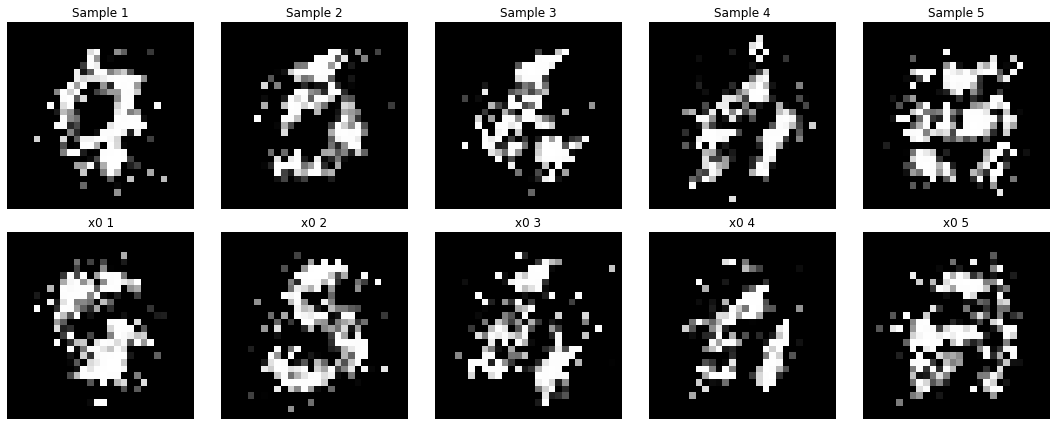

In [342]:
import matplotlib.pyplot as plt
import torch

# Assuming reverse_transform, sample_GG_CNN, and x0_noises are already defined

fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i in range(5):
    # Top row: true samples
    axes[0, i].imshow(reverse_transform(torch.tensor(sample_GG_CNN[i])).reshape(28, 28), cmap='gray')
    axes[0, i].axis('off')
    axes[0, i].set_title(f'Sample {i+1}')

    # Bottom row: x0 points
    axes[1, i].imshow(reverse_transform(torch.tensor(x0_noises[i])).reshape(28, 28), cmap='gray')
    axes[1, i].axis('off')
    axes[1, i].set_title(f'x0 {i+1}')

plt.tight_layout()
plt.show()

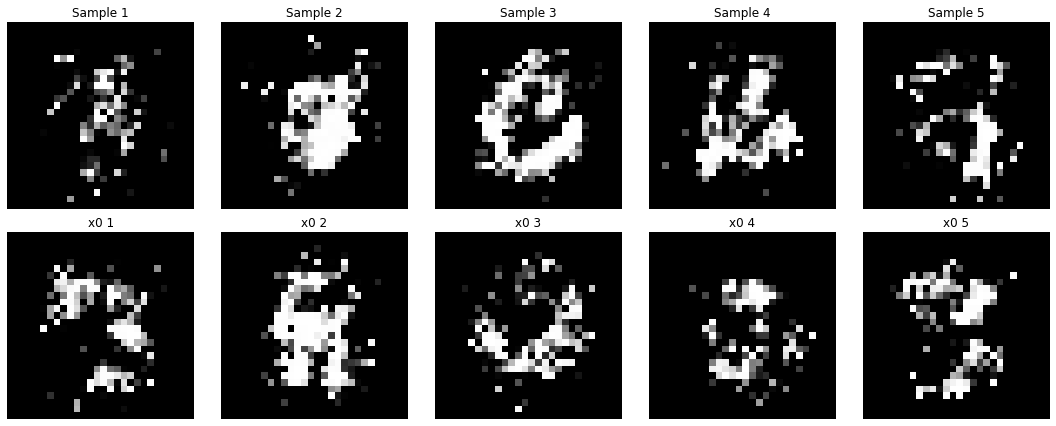

In [307]:
import matplotlib.pyplot as plt
import torch

# Assuming reverse_transform, sample_GG_CNN, and x0_noises are already defined

fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i in range(5):
    # Top row: true samples
    axes[0, i].imshow(reverse_transform(torch.tensor(sample_GG_CNN[i])).reshape(28, 28), cmap='gray')
    axes[0, i].axis('off')
    axes[0, i].set_title(f'Sample {i+1}')

    # Bottom row: x0 points
    axes[1, i].imshow(reverse_transform(torch.tensor(x0_noises[i])).reshape(28, 28), cmap='gray')
    axes[1, i].axis('off')
    axes[1, i].set_title(f'x0 {i+1}')

plt.tight_layout()
plt.show()

# simple ratio

In [323]:
from Ratio import *

def loss_nce(r_p, r_q,p_size, q_size):
    v = q_size / p_size
    return (-(r_p /(v+r_p)).log()).mean() - v* ((v/(v+r_q)).log().mean()) 


# Define model
ratio = Ratio(h_dim=100, in_dim=28*28, h_layers=2, normalising_cst=True)

# Define loss function and optimizer
optimizer = torch.optim.Adam(
    [{'params': [param for param in ratio.parameters() if param is not ratio.c]},
    {'params': [ratio.c]}]  # Adjust the learning rate for ratio.c here
)
n_indep = 10

# Training loop
num_epochs = 20

GG_cov = np.cov(X_train.reshape(-1,28*28).T)

for epoch in tqdm(range(num_epochs)):
    ratio.train()
    running_loss = 0.0
    noise_index = 0 

    epoch_GG_noise = torch.tensor(scs.multivariate_normal.rvs(mean=np.zeros(28*28), cov=GG_cov, size=n_indep*64).reshape(-1,1,28,28)).float()
    for inputs, labels in (train_loader):
        optimizer.zero_grad()
        r_p = ratio(inputs.reshape(-1,28*28)).squeeze()
        r_q = ratio( epoch_GG_noise.reshape(-1,28*28)) # torch.randn(inputs.shape).reshape(-1,1,28,28)).squeeze() #
        noise_index += inputs.shape[0]
        loss = loss_nce(r_p, r_q,inputs.shape[0], n_indep*inputs.shape[0])
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    if (epoch+1) % 1 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}, c: {ratio.c.item()}")



  5%|▌         | 1/20 [00:04<01:33,  4.93s/it]

Epoch 1/20, Loss: 0.32872349629824016, c: 1.0181527137756348


 10%|█         | 2/20 [00:10<01:32,  5.15s/it]

Epoch 2/20, Loss: 2.7066104467839067, c: 1.0324815511703491


 15%|█▌        | 3/20 [00:15<01:24,  5.00s/it]

Epoch 3/20, Loss: 2.485840407229944, c: 1.0802608728408813


 20%|██        | 4/20 [00:20<01:24,  5.30s/it]

Epoch 4/20, Loss: 1.533973142028109, c: 1.0914734601974487


 25%|██▌       | 5/20 [00:25<01:18,  5.22s/it]

Epoch 5/20, Loss: 1.2188107087286806, c: 1.1020100116729736


 30%|███       | 6/20 [00:30<01:10,  5.04s/it]

Epoch 6/20, Loss: 1.0482215861648894, c: 1.108361005783081


 35%|███▌      | 7/20 [00:35<01:04,  4.94s/it]

Epoch 7/20, Loss: 0.9358552498286212, c: 1.1139031648635864


 40%|████      | 8/20 [00:40<00:59,  4.94s/it]

Epoch 8/20, Loss: 0.905124163751536, c: 1.1158722639083862


 45%|████▌     | 9/20 [00:44<00:53,  4.88s/it]

Epoch 9/20, Loss: 0.7897727077783171, c: 1.120627999305725


 50%|█████     | 10/20 [00:49<00:48,  4.86s/it]

Epoch 10/20, Loss: 0.7125215679645411, c: 1.1237883567810059


 55%|█████▌    | 11/20 [00:55<00:45,  5.03s/it]

Epoch 11/20, Loss: 0.6889979256225675, c: 1.129150629043579


 60%|██████    | 12/20 [01:00<00:40,  5.03s/it]

Epoch 12/20, Loss: 0.6234924940308973, c: 1.1344035863876343


 65%|██████▌   | 13/20 [01:05<00:34,  4.97s/it]

Epoch 13/20, Loss: 0.6597760583736749, c: 1.1408456563949585


 70%|███████   | 14/20 [01:09<00:29,  4.93s/it]

Epoch 14/20, Loss: 0.5682563067181532, c: 1.147487759590149


 75%|███████▌  | 15/20 [01:14<00:24,  4.86s/it]

Epoch 15/20, Loss: 0.5764367566394336, c: 1.1523314714431763


 80%|████████  | 16/20 [01:19<00:19,  4.83s/it]

Epoch 16/20, Loss: 0.48529296630084007, c: 1.1556990146636963


 85%|████████▌ | 17/20 [01:24<00:14,  4.99s/it]

Epoch 17/20, Loss: 0.5347776970645385, c: 1.1615968942642212


 90%|█████████ | 18/20 [01:29<00:10,  5.06s/it]

Epoch 18/20, Loss: 0.45674041343300836, c: 1.1656838655471802


 95%|█████████▌| 19/20 [01:35<00:05,  5.11s/it]

Epoch 19/20, Loss: 0.44360158545201395, c: 1.1686841249465942


100%|██████████| 20/20 [01:39<00:00,  5.00s/it]

Epoch 20/20, Loss: 0.45466478382831, c: 1.1681149005889893


In [305]:
samples_NNEt, log_pdf_NNEt, x0_noises_NNEt = sample_GG_hmc(GG_ratio_model=model_GG_CNN, 
                            num_samples=1, 
                            num_runs_hmc=5,
                            num_burnin=150)
print(samples_NNEt.shape)

100%|██████████| 5/5 [00:34<00:00,  6.90s/it]

(5, 784)


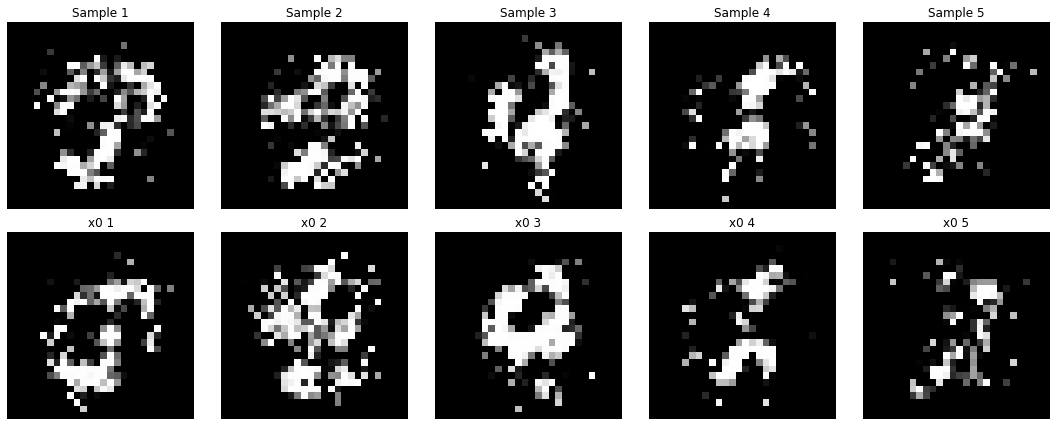

In [306]:
import matplotlib.pyplot as plt
import torch

# Assuming reverse_transform, sample_GG_CNN, and x0_noises are already defined

fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i in range(5):
    # Top row: true samples
    axes[0, i].imshow(reverse_transform(torch.tensor(samples_NNEt[i])).reshape(28, 28), cmap='gray')
    axes[0, i].axis('off')
    axes[0, i].set_title(f'Sample {i+1}')

    # Bottom row: x0 points
    axes[1, i].imshow(reverse_transform(torch.tensor(x0_noises_NNEt[i])).reshape(28, 28), cmap='gray')
    axes[1, i].axis('off')
    axes[1, i].set_title(f'x0 {i+1}')

plt.tight_layout()
plt.show()